### Overview
In this approach, a Swin baseline is used with multi task learning. Considering the previous experiments, we came to know that metadata is not helping much when used as input features. So here we tried to generate additional features and PCA and use these as output for multi task learning.  Initially model is trained on images with single output (Pawpularity).  So here we calcualted the BRISQUE which stands for Blind/Referenceless Image Spatial Quality Evaluator. It is a type of image quality assessment metric that measures how good or bad an image looks using only that image itself.  The BRISQUE lower value means image looks good while higher value means image is poor/messy. So now the SWIN is trained with two outputs (Pawpularity and BRISQUE Score). Finally the 3 PCA Components are generated and set as additional outputs which means we have now total 5 outputs for training including Pawpularity, BRISQUE, PCA1, PCA2, PCA3. 
### Benefits of multi task learning
The reason multi task learning is helpful because it encourages the model to work harder while it is learning Pawpularity and usually results in a smarter model. Hence by adding the BRISQUE improved the results while PCA's components did not add any benefit because PCA is from the input features and does not add any new extra information . 

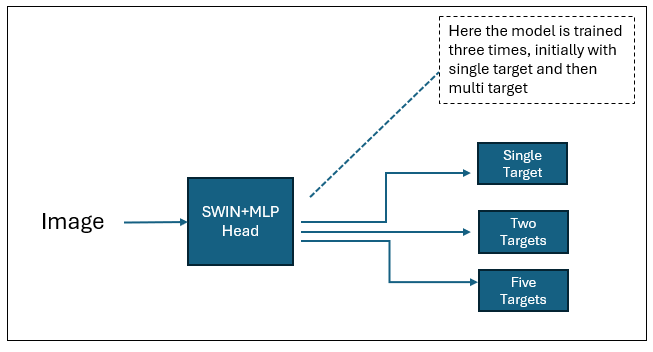

In [13]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import torch
import timm
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

DATA_ROOT = "src/inputs"
CSV_PATH = os.path.join(DATA_ROOT, "train.csv")
IMAGE_DIR = os.path.join(DATA_ROOT, "train")
OUTPUT_DIR = "src/outputs/models/swin_multitask"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 4
SEED = 42
N_FOLDS = 5
EPOCHS = 10
LR = 1e-4
WEIGHT_DECAY = 1e-5
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

METADATA_COLS = [
    "Subject Focus", "Eyes", "Face", "Near", "Action", "Accessory",
    "Group", "Collage", "Human", "Occlusion", "Info", "Blur"
]

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


Device: cuda


In [ ]:

from brisque import BRISQUE

df = pd.read_csv(CSV_PATH)
image_paths = [os.path.join(IMAGE_DIR, f"{imgid}.jpg") for imgid in df["Id"]]
brisque_scorer = BRISQUE(url=False)
brisque_scores = []
for img_fp in tqdm(image_paths, desc="BRISQUE Scoring"):
    img = Image.open(img_fp).convert("RGB")
    score = brisque_scorer.score(np.asarray(img))
    brisque_scores.append(score)
df["BRISQUE"] = brisque_scores


BRISQUE Scoring: 100%|██████████| 9912/9912 [44:47<00:00,  3.69it/s]  


In [16]:
meta_feats = df[METADATA_COLS].values
pca = PCA(n_components=3, random_state=SEED)
meta_pca = pca.fit_transform(meta_feats)
df["PCA1"] = meta_pca[:, 0]
df["PCA2"] = meta_pca[:, 1]
df["PCA3"] = meta_pca[:, 2]
df.to_csv(os.path.join(DATA_ROOT, "train_with_brisque_pca.csv"), index=False)


In [26]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,BRISQUE,PCA1,PCA2,PCA3,bins
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,26.585918,-0.054008,-0.310001,-0.461983,8
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,53.096751,-0.086572,-0.254849,-0.537469,6
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,14.421229,0.864956,0.850466,0.063672,3
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,7.979307,0.132780,-0.351114,0.129766,0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,16.796843,-1.097561,0.348604,-0.147288,9


In [ ]:
# bins for stratification
def make_stratify_bins(df, target_col="Pawpularity", n_bins=10):
    df = df.copy()
    df["bins"] = pd.qcut(df[target_col].rank(method="first"), q=n_bins, labels=False, duplicates="drop")
    return df["bins"].values

class PawpularityMultiDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms=None, cols_meta=None, multitask=True):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transforms = transforms
        self.cols_meta = cols_meta
        self.multitask = multitask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_fp = os.path.join(self.image_dir, f"{row['Id']}.jpg")
        try:
            img = Image.open(img_fp).convert("RGB")
        except Exception:
            img = Image.fromarray(np.uint8(np.random.rand(IMAGE_SIZE, IMAGE_SIZE, 3) * 255))
        if self.transforms:
            img = self.transforms(img)
        # Targets
        pawp = float(row["Pawpularity"])
        brisq = float(row["BRISQUE"])
        pca = row[["PCA1", "PCA2", "PCA3"]].values.astype(np.float32)
        task_targets = [pawp, brisq] + list(pca)
        task_targets = torch.tensor(task_targets, dtype=torch.float32)
        return img, task_targets, idx


In [18]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.2,0.2,0.2,0.1)], p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [ ]:

class SwinMultiTask(nn.Module):
    def __init__(self, out_dim=1, backbone='swin_base_patch4_window7_224'):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0)  # returns (B, C)
        self.head = nn.Linear(self.backbone.num_features, out_dim)

    def forward(self, x):
        f = self.backbone(x)          # (B, C)
        return self.head(f)           # (B, out_dim)



In [23]:
from torch.optim import AdamW

def rmse(preds, targs):
    return np.sqrt(((preds - targs) ** 2).mean())

df = pd.read_csv(os.path.join(DATA_ROOT, "train_with_brisque_pca.csv"))
df["bins"] = make_stratify_bins(df, "Pawpularity", 10)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
folds = list(skf.split(df, df["bins"].values))

n_targets = 1          # Baseline: only pawpularity
n_targets_mt2 = 2      # Pawpularity + BRISQUE
n_targets_mt5 = 5      # Paw, BRISQUE, PCA1,2,3

def train_and_eval(out_dim, output_subdir, multitask_cols, device=DEVICE):
    out_dir = os.path.join(OUTPUT_DIR, output_subdir)
    os.makedirs(out_dir, exist_ok=True)
    oof_preds = np.zeros((len(df), out_dim), dtype=np.float32)
    
    for fold, (tr_idx, val_idx) in enumerate(folds):
        print(f"\n===== {output_subdir} - Fold {fold} =====")
        train_df = df.iloc[tr_idx].reset_index(drop=True)
        valid_df = df.iloc[val_idx].reset_index(drop=True)
        train_ds = PawpularityMultiDataset(train_df, IMAGE_DIR, transforms=train_transforms, multitask=True)
        valid_ds = PawpularityMultiDataset(valid_df, IMAGE_DIR, transforms=valid_transforms, multitask=True)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
        valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS)
        
        model = SwinMultiTask(out_dim=out_dim).to(device)
        optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)
        criterion = nn.BCEWithLogitsLoss()
        best_rmse = 1e9
        best_epoch = -1
        wait = 0
        
        for epoch in range(EPOCHS):
            model.train()
            train_losses = []
            for imgs, targets, _ in tqdm(train_loader, desc=f"{output_subdir} F{fold} E{epoch}"):
                imgs = imgs.to(device)
                targets = targets[:, :out_dim].to(device)   # pick relevant target columns
                # Normalize targets for BCE
                targets_norm = targets / 100.0
                preds = model(imgs)
                loss = criterion(preds, targets_norm)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            # Validation
            model.eval()
            val_preds = []
            val_targs = []
            with torch.no_grad():
                for imgs, targets, _ in valid_loader:
                    imgs = imgs.to(device)
                    targets = targets[:, :out_dim].to(device)
                    targets_norm = targets / 100.0
                    preds = model(imgs)
                    val_preds.append(torch.sigmoid(preds).cpu().numpy() * 100.0)
                    val_targs.append(targets.cpu().numpy())
            val_preds = np.concatenate(val_preds)
            val_targs = np.concatenate(val_targs)
            val_rmse = rmse(val_preds[:,0], val_targs[:,0])
            print(f"Epoch {epoch} - Val RMSE (pawpularity): {val_rmse:.4f} - Best: {best_rmse:.4f}")
            scheduler.step(val_rmse)
            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_epoch = epoch
                wait = 0
                torch.save(model.state_dict(), os.path.join(out_dir, f"fold{fold}_best.pth"))
                print("Saved best:", os.path.join(out_dir, f"fold{fold}_best.pth"))
            else:
                wait += 1
                if wait >= PATIENCE:
                    print("Early stopping")
                    break
        # Evaluate OOF best
        model.load_state_dict(torch.load(os.path.join(out_dir, f"fold{fold}_best.pth")))
        model.eval()
        val_preds = []
        with torch.no_grad():
            for imgs, _, idxs in torch.utils.data.DataLoader(
                valid_ds, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=NUM_WORKERS):
                imgs = imgs.to(device)
                preds = model(imgs)
                val_preds.append(torch.sigmoid(preds).cpu().numpy() * 100.0)
        val_preds = np.concatenate(val_preds, axis=0)
        oof_preds[val_idx, :] = val_preds
        print(f"Fold {fold} finished. Best epoch: {best_epoch}, Best RMSE: {best_rmse:.4f}")
    # Save OOF
    df_oof = df.copy()
    for i, col in enumerate(multitask_cols):
        df_oof[f"oof_pred_{col}"] = oof_preds[:, i]
    oof_path = os.path.join(out_dir, "oof_preds.csv")
    df_oof.to_csv(oof_path, index=False)
    print("Saved OOF to:", oof_path)
    overall_rmse_val = rmse(df_oof["oof_pred_pawpularity"].values, df_oof["Pawpularity"].values)
    print(f"Final OOF RMSE (pawpularity) for {output_subdir}: {overall_rmse_val:.4f}")
    return overall_rmse_val


In [24]:
# 1. Pawpularity only
train_and_eval(
    out_dim=1,
    output_subdir="paw_only",
    multitask_cols=["pawpularity"]
)

# 2. Pawpularity + BRISQUE
train_and_eval(
    out_dim=2,
    output_subdir="paw_brisque",
    multitask_cols=["pawpularity","BRISQUE"]
)

# 3. Pawpularity + BRISQUE + PCA
train_and_eval(
    out_dim=5,
    output_subdir="paw_brisque_pca",
    multitask_cols=["pawpularity","BRISQUE","PCA1","PCA2","PCA3"]
)



===== paw_only - Fold 0 =====


paw_only F0 E0: 100%|██████████| 496/496 [01:18<00:00,  6.34it/s]


Epoch 0 - Val RMSE (pawpularity): 20.4900 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E1: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 1 - Val RMSE (pawpularity): 20.4826 - Best: 20.4900
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E2: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 2 - Val RMSE (pawpularity): 19.4010 - Best: 20.4826
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E3: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 3 - Val RMSE (pawpularity): 19.1472 - Best: 19.4010
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E4: 100%|██████████| 496/496 [00:58<00:00,  8.47it/s]


Epoch 4 - Val RMSE (pawpularity): 19.0099 - Best: 19.1472
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E5: 100%|██████████| 496/496 [00:58<00:00,  8.44it/s]


Epoch 5 - Val RMSE (pawpularity): 18.8844 - Best: 19.0099
Saved best: src/outputs/models/swin_multitask/paw_only/fold0_best.pth


paw_only F0 E6: 100%|██████████| 496/496 [00:58<00:00,  8.48it/s]


Epoch 6 - Val RMSE (pawpularity): 19.0014 - Best: 18.8844


paw_only F0 E7: 100%|██████████| 496/496 [00:58<00:00,  8.48it/s]


Epoch 7 - Val RMSE (pawpularity): 19.1103 - Best: 18.8844


paw_only F0 E8: 100%|██████████| 496/496 [00:58<00:00,  8.49it/s]


Epoch 8 - Val RMSE (pawpularity): 19.0769 - Best: 18.8844


paw_only F0 E9: 100%|██████████| 496/496 [00:58<00:00,  8.49it/s]


Epoch 9 - Val RMSE (pawpularity): 19.3866 - Best: 18.8844
Fold 0 finished. Best epoch: 5, Best RMSE: 18.8844

===== paw_only - Fold 1 =====


paw_only F1 E0: 100%|██████████| 496/496 [00:58<00:00,  8.45it/s]


Epoch 0 - Val RMSE (pawpularity): 19.5548 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_only/fold1_best.pth


paw_only F1 E1: 100%|██████████| 496/496 [00:58<00:00,  8.46it/s]


Epoch 1 - Val RMSE (pawpularity): 18.7538 - Best: 19.5548
Saved best: src/outputs/models/swin_multitask/paw_only/fold1_best.pth


paw_only F1 E2: 100%|██████████| 496/496 [00:58<00:00,  8.49it/s]


Epoch 2 - Val RMSE (pawpularity): 19.3205 - Best: 18.7538


paw_only F1 E3: 100%|██████████| 496/496 [00:57<00:00,  8.60it/s]


Epoch 3 - Val RMSE (pawpularity): 19.6334 - Best: 18.7538


paw_only F1 E4: 100%|██████████| 496/496 [00:57<00:00,  8.60it/s]


Epoch 4 - Val RMSE (pawpularity): 20.2420 - Best: 18.7538


paw_only F1 E5: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 5 - Val RMSE (pawpularity): 19.4815 - Best: 18.7538


paw_only F1 E6: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 6 - Val RMSE (pawpularity): 19.4432 - Best: 18.7538
Early stopping
Fold 1 finished. Best epoch: 1, Best RMSE: 18.7538

===== paw_only - Fold 2 =====


paw_only F2 E0: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 0 - Val RMSE (pawpularity): 18.6482 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_only/fold2_best.pth


paw_only F2 E1: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 1 - Val RMSE (pawpularity): 19.0525 - Best: 18.6482


paw_only F2 E2: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 2 - Val RMSE (pawpularity): 19.4826 - Best: 18.6482


paw_only F2 E3: 100%|██████████| 496/496 [00:58<00:00,  8.53it/s]


Epoch 3 - Val RMSE (pawpularity): 19.3038 - Best: 18.6482


paw_only F2 E4: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 4 - Val RMSE (pawpularity): 19.3907 - Best: 18.6482


paw_only F2 E5: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 5 - Val RMSE (pawpularity): 19.5091 - Best: 18.6482
Early stopping
Fold 2 finished. Best epoch: 0, Best RMSE: 18.6482

===== paw_only - Fold 3 =====


paw_only F3 E0: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 0 - Val RMSE (pawpularity): 18.5624 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_only/fold3_best.pth


paw_only F3 E1: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 1 - Val RMSE (pawpularity): 18.5503 - Best: 18.5624
Saved best: src/outputs/models/swin_multitask/paw_only/fold3_best.pth


paw_only F3 E2: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 2 - Val RMSE (pawpularity): 19.5286 - Best: 18.5503


paw_only F3 E3: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 3 - Val RMSE (pawpularity): 18.9668 - Best: 18.5503


paw_only F3 E4: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 4 - Val RMSE (pawpularity): 19.4524 - Best: 18.5503


paw_only F3 E5: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 5 - Val RMSE (pawpularity): 19.5972 - Best: 18.5503


paw_only F3 E6: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 6 - Val RMSE (pawpularity): 19.3360 - Best: 18.5503
Early stopping
Fold 3 finished. Best epoch: 1, Best RMSE: 18.5503

===== paw_only - Fold 4 =====


paw_only F4 E0: 100%|██████████| 496/496 [00:57<00:00,  8.60it/s]


Epoch 0 - Val RMSE (pawpularity): 18.6860 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_only/fold4_best.pth


paw_only F4 E1: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 1 - Val RMSE (pawpularity): 18.8468 - Best: 18.6860


paw_only F4 E2: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 2 - Val RMSE (pawpularity): 18.8260 - Best: 18.6860


paw_only F4 E3: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 3 - Val RMSE (pawpularity): 18.9657 - Best: 18.6860


paw_only F4 E4: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 4 - Val RMSE (pawpularity): 18.5699 - Best: 18.6860
Saved best: src/outputs/models/swin_multitask/paw_only/fold4_best.pth


paw_only F4 E5: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 5 - Val RMSE (pawpularity): 19.5186 - Best: 18.5699


paw_only F4 E6: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 6 - Val RMSE (pawpularity): 19.1333 - Best: 18.5699


paw_only F4 E7: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 7 - Val RMSE (pawpularity): 19.4044 - Best: 18.5699


paw_only F4 E8: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 8 - Val RMSE (pawpularity): 19.0866 - Best: 18.5699


paw_only F4 E9: 100%|██████████| 496/496 [00:58<00:00,  8.52it/s]


Epoch 9 - Val RMSE (pawpularity): 19.1527 - Best: 18.5699
Early stopping
Fold 4 finished. Best epoch: 4, Best RMSE: 18.5699
Saved OOF to: src/outputs/models/swin_multitask/paw_only/oof_preds.csv
Final OOF RMSE (pawpularity) for paw_only: 18.6818

===== paw_brisque - Fold 0 =====


paw_brisque F0 E0: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 0 - Val RMSE (pawpularity): 18.4115 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold0_best.pth


paw_brisque F0 E1: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 1 - Val RMSE (pawpularity): 18.8265 - Best: 18.4115


paw_brisque F0 E2: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 2 - Val RMSE (pawpularity): 18.5948 - Best: 18.4115


paw_brisque F0 E3: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 3 - Val RMSE (pawpularity): 18.5448 - Best: 18.4115


paw_brisque F0 E4: 100%|██████████| 496/496 [00:58<00:00,  8.45it/s]


Epoch 4 - Val RMSE (pawpularity): 18.9495 - Best: 18.4115


paw_brisque F0 E5: 100%|██████████| 496/496 [00:58<00:00,  8.46it/s]


Epoch 5 - Val RMSE (pawpularity): 18.7985 - Best: 18.4115
Early stopping
Fold 0 finished. Best epoch: 0, Best RMSE: 18.4115

===== paw_brisque - Fold 1 =====


paw_brisque F1 E0: 100%|██████████| 496/496 [00:58<00:00,  8.44it/s]


Epoch 0 - Val RMSE (pawpularity): 18.8820 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold1_best.pth


paw_brisque F1 E1: 100%|██████████| 496/496 [00:58<00:00,  8.44it/s]


Epoch 1 - Val RMSE (pawpularity): 18.6595 - Best: 18.8820
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold1_best.pth


paw_brisque F1 E2: 100%|██████████| 496/496 [00:58<00:00,  8.41it/s]


Epoch 2 - Val RMSE (pawpularity): 19.0619 - Best: 18.6595


paw_brisque F1 E3: 100%|██████████| 496/496 [00:58<00:00,  8.43it/s]


Epoch 3 - Val RMSE (pawpularity): 19.7630 - Best: 18.6595


paw_brisque F1 E4: 100%|██████████| 496/496 [00:58<00:00,  8.44it/s]


Epoch 4 - Val RMSE (pawpularity): 19.8535 - Best: 18.6595


paw_brisque F1 E5: 100%|██████████| 496/496 [00:58<00:00,  8.45it/s]


Epoch 5 - Val RMSE (pawpularity): 19.3930 - Best: 18.6595


paw_brisque F1 E6: 100%|██████████| 496/496 [00:58<00:00,  8.45it/s]


Epoch 6 - Val RMSE (pawpularity): 19.4851 - Best: 18.6595
Early stopping
Fold 1 finished. Best epoch: 1, Best RMSE: 18.6595

===== paw_brisque - Fold 2 =====


paw_brisque F2 E0: 100%|██████████| 496/496 [00:58<00:00,  8.42it/s]


Epoch 0 - Val RMSE (pawpularity): 19.2789 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold2_best.pth


paw_brisque F2 E1: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 1 - Val RMSE (pawpularity): 19.8337 - Best: 19.2789


paw_brisque F2 E2: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 2 - Val RMSE (pawpularity): 18.7750 - Best: 19.2789
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold2_best.pth


paw_brisque F2 E3: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 3 - Val RMSE (pawpularity): 19.2416 - Best: 18.7750


paw_brisque F2 E4: 100%|██████████| 496/496 [00:58<00:00,  8.53it/s]


Epoch 4 - Val RMSE (pawpularity): 19.1300 - Best: 18.7750


paw_brisque F2 E5: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 5 - Val RMSE (pawpularity): 20.0233 - Best: 18.7750


paw_brisque F2 E6: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 6 - Val RMSE (pawpularity): 19.3589 - Best: 18.7750


paw_brisque F2 E7: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 7 - Val RMSE (pawpularity): 19.2774 - Best: 18.7750
Early stopping
Fold 2 finished. Best epoch: 2, Best RMSE: 18.7750

===== paw_brisque - Fold 3 =====


paw_brisque F3 E0: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 0 - Val RMSE (pawpularity): 19.5509 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold3_best.pth


paw_brisque F3 E1: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 1 - Val RMSE (pawpularity): 19.8957 - Best: 19.5509


paw_brisque F3 E2: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 2 - Val RMSE (pawpularity): 18.6656 - Best: 19.5509
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold3_best.pth


paw_brisque F3 E3: 100%|██████████| 496/496 [00:57<00:00,  8.55it/s]


Epoch 3 - Val RMSE (pawpularity): 19.3811 - Best: 18.6656


paw_brisque F3 E4: 100%|██████████| 496/496 [00:57<00:00,  8.55it/s]


Epoch 4 - Val RMSE (pawpularity): 19.3779 - Best: 18.6656


paw_brisque F3 E5: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 5 - Val RMSE (pawpularity): 19.5470 - Best: 18.6656


paw_brisque F3 E6: 100%|██████████| 496/496 [00:58<00:00,  8.53it/s]


Epoch 6 - Val RMSE (pawpularity): 18.9837 - Best: 18.6656


paw_brisque F3 E7: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 7 - Val RMSE (pawpularity): 18.9303 - Best: 18.6656
Early stopping
Fold 3 finished. Best epoch: 2, Best RMSE: 18.6656

===== paw_brisque - Fold 4 =====


paw_brisque F4 E0: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 0 - Val RMSE (pawpularity): 19.2284 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold4_best.pth


paw_brisque F4 E1: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 1 - Val RMSE (pawpularity): 18.4143 - Best: 19.2284
Saved best: src/outputs/models/swin_multitask/paw_brisque/fold4_best.pth


paw_brisque F4 E2: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 2 - Val RMSE (pawpularity): 19.0227 - Best: 18.4143


paw_brisque F4 E3: 100%|██████████| 496/496 [00:58<00:00,  8.53it/s]


Epoch 3 - Val RMSE (pawpularity): 19.0787 - Best: 18.4143


paw_brisque F4 E4: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 4 - Val RMSE (pawpularity): 19.1936 - Best: 18.4143


paw_brisque F4 E5: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 5 - Val RMSE (pawpularity): 19.1654 - Best: 18.4143


paw_brisque F4 E6: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 6 - Val RMSE (pawpularity): 19.2743 - Best: 18.4143
Early stopping
Fold 4 finished. Best epoch: 1, Best RMSE: 18.4143
Saved OOF to: src/outputs/models/swin_multitask/paw_brisque/oof_preds.csv
Final OOF RMSE (pawpularity) for paw_brisque: 18.5857

===== paw_brisque_pca - Fold 0 =====


paw_brisque_pca F0 E0: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 0 - Val RMSE (pawpularity): 20.3684 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold0_best.pth


paw_brisque_pca F0 E1: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 1 - Val RMSE (pawpularity): 19.1040 - Best: 20.3684
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold0_best.pth


paw_brisque_pca F0 E2: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 2 - Val RMSE (pawpularity): 19.2179 - Best: 19.1040


paw_brisque_pca F0 E3: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 3 - Val RMSE (pawpularity): 18.7794 - Best: 19.1040
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold0_best.pth


paw_brisque_pca F0 E4: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 4 - Val RMSE (pawpularity): 19.0614 - Best: 18.7794


paw_brisque_pca F0 E5: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 5 - Val RMSE (pawpularity): 20.2279 - Best: 18.7794


paw_brisque_pca F0 E6: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 6 - Val RMSE (pawpularity): 20.2884 - Best: 18.7794


paw_brisque_pca F0 E7: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 7 - Val RMSE (pawpularity): 18.9350 - Best: 18.7794


paw_brisque_pca F0 E8: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 8 - Val RMSE (pawpularity): 18.4947 - Best: 18.7794
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold0_best.pth


paw_brisque_pca F0 E9: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 9 - Val RMSE (pawpularity): 18.5595 - Best: 18.4947
Fold 0 finished. Best epoch: 8, Best RMSE: 18.4947

===== paw_brisque_pca - Fold 1 =====


paw_brisque_pca F1 E0: 100%|██████████| 496/496 [00:58<00:00,  8.51it/s]


Epoch 0 - Val RMSE (pawpularity): 20.9807 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold1_best.pth


paw_brisque_pca F1 E1: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 1 - Val RMSE (pawpularity): 19.0078 - Best: 20.9807
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold1_best.pth


paw_brisque_pca F1 E2: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 2 - Val RMSE (pawpularity): 19.9967 - Best: 19.0078


paw_brisque_pca F1 E3: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 3 - Val RMSE (pawpularity): 18.9908 - Best: 19.0078
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold1_best.pth


paw_brisque_pca F1 E4: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 4 - Val RMSE (pawpularity): 22.3425 - Best: 18.9908


paw_brisque_pca F1 E5: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 5 - Val RMSE (pawpularity): 20.4758 - Best: 18.9908


paw_brisque_pca F1 E6: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 6 - Val RMSE (pawpularity): 18.9897 - Best: 18.9908
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold1_best.pth


paw_brisque_pca F1 E7: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 7 - Val RMSE (pawpularity): 19.5565 - Best: 18.9897


paw_brisque_pca F1 E8: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 8 - Val RMSE (pawpularity): 19.2487 - Best: 18.9897


paw_brisque_pca F1 E9: 100%|██████████| 496/496 [00:58<00:00,  8.53it/s]


Epoch 9 - Val RMSE (pawpularity): 19.1230 - Best: 18.9897
Fold 1 finished. Best epoch: 6, Best RMSE: 18.9897

===== paw_brisque_pca - Fold 2 =====


paw_brisque_pca F2 E0: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 0 - Val RMSE (pawpularity): 18.8818 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold2_best.pth


paw_brisque_pca F2 E1: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 1 - Val RMSE (pawpularity): 21.7301 - Best: 18.8818


paw_brisque_pca F2 E2: 100%|██████████| 496/496 [00:57<00:00,  8.60it/s]


Epoch 2 - Val RMSE (pawpularity): 19.3972 - Best: 18.8818


paw_brisque_pca F2 E3: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 3 - Val RMSE (pawpularity): 19.0573 - Best: 18.8818


paw_brisque_pca F2 E4: 100%|██████████| 496/496 [00:58<00:00,  8.54it/s]


Epoch 4 - Val RMSE (pawpularity): 18.8124 - Best: 18.8818
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold2_best.pth


paw_brisque_pca F2 E5: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 5 - Val RMSE (pawpularity): 19.5065 - Best: 18.8124


paw_brisque_pca F2 E6: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 6 - Val RMSE (pawpularity): 18.8623 - Best: 18.8124


paw_brisque_pca F2 E7: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 7 - Val RMSE (pawpularity): 19.6282 - Best: 18.8124


paw_brisque_pca F2 E8: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 8 - Val RMSE (pawpularity): 19.5122 - Best: 18.8124


paw_brisque_pca F2 E9: 100%|██████████| 496/496 [00:58<00:00,  8.52it/s]


Epoch 9 - Val RMSE (pawpularity): 19.2328 - Best: 18.8124
Early stopping
Fold 2 finished. Best epoch: 4, Best RMSE: 18.8124

===== paw_brisque_pca - Fold 3 =====


paw_brisque_pca F3 E0: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 0 - Val RMSE (pawpularity): 18.7319 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold3_best.pth


paw_brisque_pca F3 E1: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 1 - Val RMSE (pawpularity): 19.1906 - Best: 18.7319


paw_brisque_pca F3 E2: 100%|██████████| 496/496 [00:57<00:00,  8.60it/s]


Epoch 2 - Val RMSE (pawpularity): 19.7331 - Best: 18.7319


paw_brisque_pca F3 E3: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 3 - Val RMSE (pawpularity): 20.2378 - Best: 18.7319


paw_brisque_pca F3 E4: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 4 - Val RMSE (pawpularity): 18.9656 - Best: 18.7319


paw_brisque_pca F3 E5: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 5 - Val RMSE (pawpularity): 18.7311 - Best: 18.7319
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold3_best.pth


paw_brisque_pca F3 E6: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 6 - Val RMSE (pawpularity): 18.8670 - Best: 18.7311


paw_brisque_pca F3 E7: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 7 - Val RMSE (pawpularity): 18.7493 - Best: 18.7311


paw_brisque_pca F3 E8: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 8 - Val RMSE (pawpularity): 18.8320 - Best: 18.7311


paw_brisque_pca F3 E9: 100%|██████████| 496/496 [00:57<00:00,  8.59it/s]


Epoch 9 - Val RMSE (pawpularity): 18.8462 - Best: 18.7311
Fold 3 finished. Best epoch: 5, Best RMSE: 18.7311

===== paw_brisque_pca - Fold 4 =====


paw_brisque_pca F4 E0: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 0 - Val RMSE (pawpularity): 19.5135 - Best: 1000000000.0000
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold4_best.pth


paw_brisque_pca F4 E1: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 1 - Val RMSE (pawpularity): 18.6561 - Best: 19.5135
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold4_best.pth


paw_brisque_pca F4 E2: 100%|██████████| 496/496 [00:57<00:00,  8.57it/s]


Epoch 2 - Val RMSE (pawpularity): 19.2894 - Best: 18.6561


paw_brisque_pca F4 E3: 100%|██████████| 496/496 [00:58<00:00,  8.55it/s]


Epoch 3 - Val RMSE (pawpularity): 18.6138 - Best: 18.6561
Saved best: src/outputs/models/swin_multitask/paw_brisque_pca/fold4_best.pth


paw_brisque_pca F4 E4: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 4 - Val RMSE (pawpularity): 21.1849 - Best: 18.6138


paw_brisque_pca F4 E5: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 5 - Val RMSE (pawpularity): 19.1064 - Best: 18.6138


paw_brisque_pca F4 E6: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 6 - Val RMSE (pawpularity): 20.3414 - Best: 18.6138


paw_brisque_pca F4 E7: 100%|██████████| 496/496 [00:57<00:00,  8.58it/s]


Epoch 7 - Val RMSE (pawpularity): 19.1709 - Best: 18.6138


paw_brisque_pca F4 E8: 100%|██████████| 496/496 [00:57<00:00,  8.56it/s]


Epoch 8 - Val RMSE (pawpularity): 18.8284 - Best: 18.6138
Early stopping
Fold 4 finished. Best epoch: 3, Best RMSE: 18.6138
Saved OOF to: src/outputs/models/swin_multitask/paw_brisque_pca/oof_preds.csv
Final OOF RMSE (pawpularity) for paw_brisque_pca: 18.7291


np.float64(18.7291264944087)

In [ ]:
import pandas as pd
import numpy as np
import os


def rmse(preds, targs):
    return np.sqrt(((preds - targs) ** 2).mean())


experiments = {
    "Baseline (Paw Only)": "paw_only",
    "Multitask (Paw + BRISQUE)": "paw_brisque",
    "Multitask (Paw + 5 Targets)": "paw_brisque_pca"
}

print(f"{'EXPERIMENT':<30} | {'RMSE':<10}")
print("-" * 45)

# Loop through saved files and calculate RMSE
for name, folder in experiments.items():
    # Construct path to the saved OOF file
    oof_path = os.path.join(OUTPUT_DIR, folder, "oof_preds.csv")
    
    if os.path.exists(oof_path):
        df_oof = pd.read_csv(oof_path)
        # Calculate RMSE between actual 'Pawpularity' and prediction
        score = rmse(df_oof["oof_pred_pawpularity"], df_oof["Pawpularity"])
        print(f"{name:<30} | {score:.4f}")
    else:
        print(f"{name:<30} | File not found")

EXPERIMENT                     | RMSE      
---------------------------------------------
Baseline (Paw Only)            | 18.6818
Multitask (Paw + BRISQUE)      | 18.5857
Multitask (Paw + 5 Targets)    | 18.7291
